<a href="https://colab.research.google.com/github/mhmdahmd2422/CNN-MLP-CroppedYale/blob/main/CroppedYale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).




# Import modules and define functions

Import necessary modules

In [ ]:
import numpy as np
import glob
import math
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

A function that loads dataset images into a Numpy array and create coresponding label for each subject. *Returns X for data, y for labels.*

In [ ]:
def load_sowar():
    # 7ot el sowar fe list
    sowar_list = []
    for path in glob.glob('gdrive/MyDrive/CroppedYale/*/*.pgm'):
        sora = Image.open(path)
        sowar_list.append(np.array(sora))
    #print(len(sowar_list))
    # 7ot el list fe numpi array
    X = np.stack(sowar_list)

    # e3mel rakam (label) le kol sha5s (subject/target)
    y = np.zeros((2414,))
    for i in range(38):
        y[i*64:i*64+64] = i

    return X, y

A function that uses matplotlib to visualize and preview some of the data with their corresponding labels.

In [ ]:
# preview lel sowar
# TODO: kol sora tezhar mara wa7da bas
def plot_images(images):
  plt.figure(figsize=(12, 12))
  len_ = int(math.sqrt(len(images)))
  for y in range(len_):
    for x in range(len_):
      ind = y * len_ + x
      plt.subplot(len_, len_, ind+1)
      plt.imshow(images[ind])
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(y_train[ind])
  plt.show()

A function that uses matplotlib to visualize and preview training and validation sets' accuracy and loss with respect to Epochs. *Expects fit() callback object output as a parameter.*

In [ ]:
# TODO: 7ot dol fe function
def compare_metrics(history):
  # plot el accuracy
  plt.plot(history.history["accuracy"], label="Train Acc")
  plt.plot(history.history["val_accuracy"], label="Val. Acc")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Acc.")
  plt.show()
  print('\n\n')
# plot el loss
  plt.plot(history.history["loss"], label="Train loss")
  plt.plot(history.history["val_loss"], label="Val. loss")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

# Load and Split Dataset

This block calls the dataset loading function,
shuffle data with respect to label order,
normalize pixel values from 255 range to 1 range,
split the dataset to train and test sets with 20% share to test set,
further split the test set to test and validation sets with 10% share to validation set,
call the data visualization function for preview.

(2414, 192, 168)
(2414,)


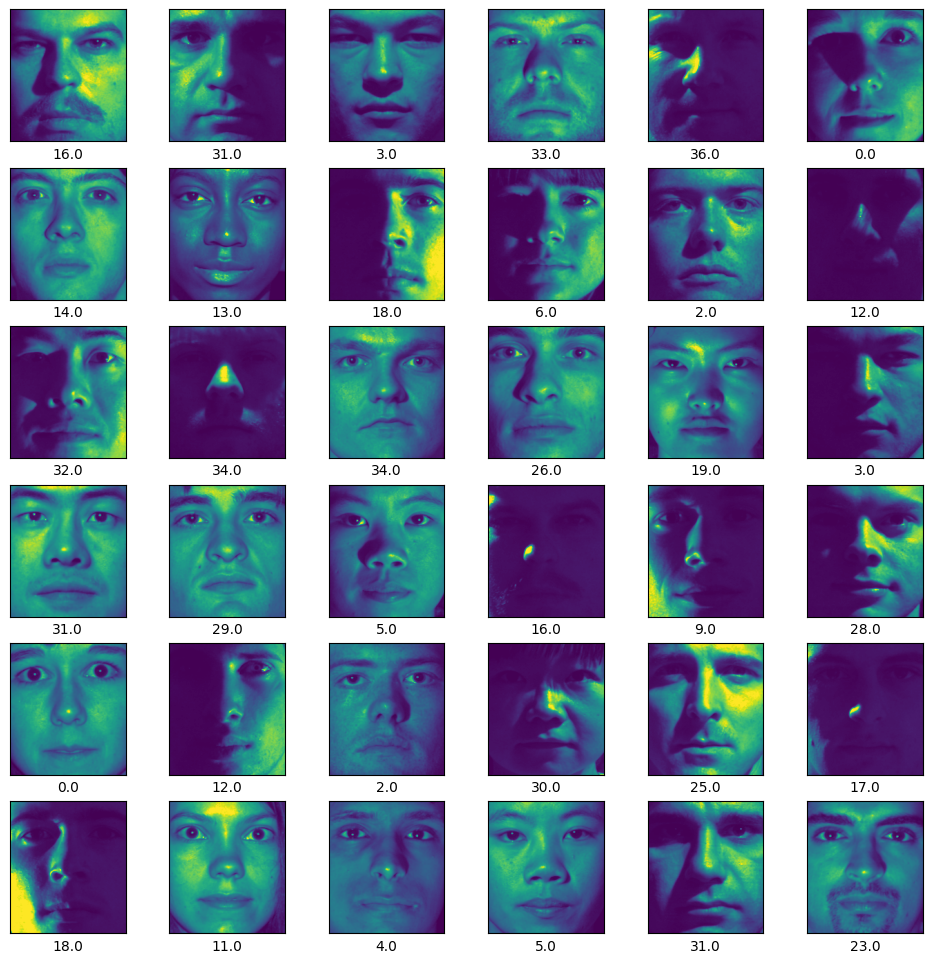

In [ ]:
# Load el data
X, y = load_sowar()
print(X.shape)
print(y.shape)
# fannat el data
X, y = shuffle(X, y)
# normalize el pixel values
X = X.astype('float32') / 255.0
# asem el data train w test w validation
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
# preview lel data fe plot
plot_images(X_train[:36])

# MLP Model

Build a Sequential Multi-Layer Percepton model with 4 layer architecture

> *   Input layer (input shape of true size)
*   2 hidden layers (Relu activation function)
*   Output layer (Softmax activation function)



---


Preview a summary of the architecture and the resulting parameters count.

---

Compile the model with **Adam** optimizer & **Categorial Cross Entropy** loss function. (Default learning rate)


---


Define an early stopping callback function to prevent overfitting, it monitors validation loss metric for epochs and recall previous weights when triggered.



---

Fit the compiled model and pass the training set, desired number of Epochs,defined callbacks, validation set for monitoring, `and encourage data shuffle after every Epoch`. *Return metrics of the fiting process*

---

Lastly, Evaluate the model on the test set (Unseen Data) and preview the measured accuracy for the set.


In [ ]:
print("===========MLP Model Start===========\n\n")
# ebny el MLP
model_MLP = models.Sequential()
# arb3a layers w e7tmal nezwed
model_MLP.add(layers.Flatten(input_shape=(192, 168)))
# model_MLP.add(layers.Dense(256, activation="relu"))
model_MLP.add(layers.Dense(128, activation="relu"))
# model_MLP.add(layers.Dropout(0.2))
model_MLP.add(layers.Dense(64, activation="relu"))
# model_MLP.add(layers.Dropout(0.2))
model_MLP.add(layers.Dense(38, activation="softmax"))
# check el parameters
model_MLP.summary()
# 7ot el optimizer w loss
model_MLP.compile(optimizer="adam",loss=losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])
# e3mel early stopping w rga3 el weights lw el epochs keter w el accuracy bda2 ye2el
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
# edee awalany w etla3 (shuffle?)
history_MLP = model_MLP.fit(X_train, y_train, epochs=25, callbacks=earlystopping, validation_data=(X_val_test, y_val_test))
print('\n\n=========Evaluation On Test Set=========')
results_MLP = model_MLP.evaluate(X_test, y_test)
print('\n\n')

===========MLP Model Start===========


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 32256)             0         
                                                                 
 dense (Dense)               (None, 128)               4128896   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 38)                2470      
                                                                 
Total params: 4,139,622
Trainable params: 4,139,622
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
61/61 [==============================] - 3s 12ms/step - loss: 4.2149 - accuracy: 0.0404 - val_loss: 3.4862 - val_accuracy: 0.07

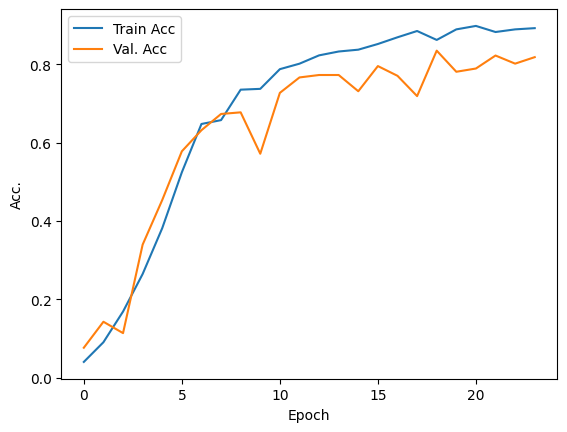

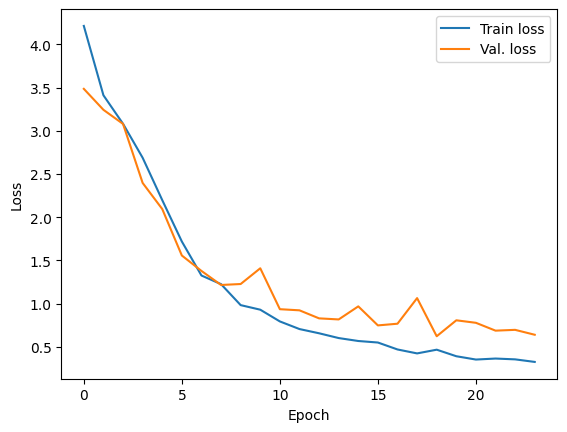

In [ ]:
compare_metrics(history_MLP)

# CNN Model

Build a Sequential Convolutional Neural Network model with 9 layer architecture

> *   Input 2D-Conv layer (input shape of true size **[32 filters with (3,3) Strides]** + Relu activation function)
*   2 2D-Conv hidden layers (Relu activation function)
*   3 Max-pooling layers (Pool size of (2,2) with (3,3) strides)
*   Flattening layer
*   1 Dense layer (Relu activation function)
*   Output layer (Softmax activation function)



---


Preview a summary of the architecture and the resulting parameters count.

---

Compile the model with **Adam** optimizer & **Categorial Cross Entropy** loss function. (Default learning rate)


---


Define an early stopping callback function to prevent overfitting, it monitors validation loss metric for epochs and recall previous weights when triggered.



---

Fit the compiled model and pass the training set, desired number of Epochs,defined callbacks, validation set for monitoring,` and encourage data shuffle after every Epoch.` *Return metrics of the fiting process*

---

Lastly, Evaluate the model on the test set (Unseen Data) and preview the measured accuracy for the set.

In [ ]:
# ebny el CNN
model_CNN = models.Sequential()
# talta conv layers b2znellah
# add dropout layers
model_CNN.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(192, 168, 1)))
model_CNN.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# model_CNN.add(layers.Dropout(0.2))
model_CNN.add(layers.Conv2D(64, (3, 3), activation="relu"))
model_CNN.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# model_CNN.add(layers.Dropout(0.2))
model_CNN.add(layers.Conv2D(128, (3, 3), activation="relu"))
model_CNN.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# model_CNN.add(layers.Dropout(0.2))
# check el parameters
# model_CNN.summary()
# nefred b3d ma faltarna
model_CNN.add(layers.Flatten())
# ne-classify b2a
model_CNN.add(layers.Dense(64, activation="relu"))
model_CNN.add(layers.Dense(38, activation="softmax"))
# check el parameters tany
model_CNN.summary()
# 7ot el optimizer w loss
model_CNN.compile(optimizer="adam",loss=losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])
# TODO: need earlystopping??
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
# besmellah
history_CNN = model_CNN.fit(X_train, y_train, epochs=5, callbacks=earlystopping, validation_data=(X_val_test, y_val_test))
print('\n\n=========Evaluation On Test Set=========')
results_CNN = model_CNN.evaluate(X_test, y_test)
print('\n\n')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 166, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 83, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 81, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 38, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 19, 128)     

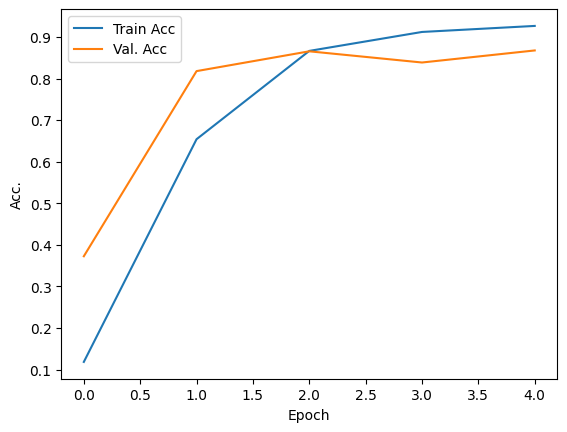

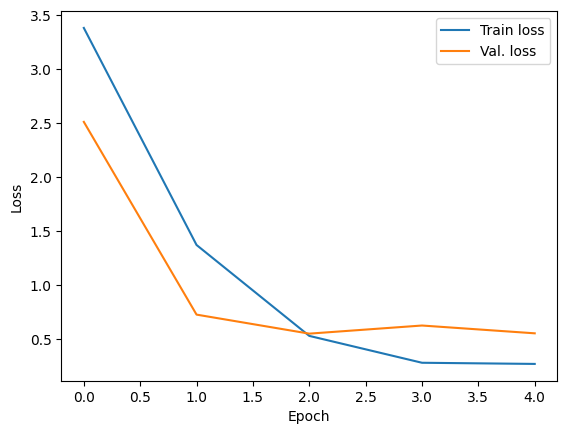

In [ ]:
compare_metrics(history_CNN)

# Augment Dataset

This block apply some augmentation on training set to produce a more diverse and quantitve set for better results. the augmentation include rotation, shifting, zooming, and flipping. finally it add the produced augmentation to our original dataset to output *X_train_augmented* and *y_train_augmented*.

In [ ]:
# augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,  # rotate images by 20 degrees
    width_shift_range=0.2,  # shift images horizontally by 10%
    height_shift_range=0.2,  # shift images vertically by 10%
    zoom_range=0.2,  # zoom in/out on images by 20%
    horizontal_flip=True,  # flip images horizontally
    vertical_flip=True  # flip images vertically
)
# 8yar el rank le 4 3shan ne-fit (guard b while loop 3shan ntamen)
while(X_train.ndim > 4):
  X_train = np.squeeze(X_train, axis=-1)
while(X_train.ndim < 4):
  X_train = np.expand_dims(X_train, axis=-1)
# sh8al el generator w ebd2 el flow
datagen.fit(X_train)
augmented_data = datagen.flow(X_train, y_train, batch_size=32)
# print(len(augmented_data))
# concatenate original training set with augmented set b3d ma n7welha men tuples le numpy
augmented_X, augmented_y = [], []
num_batches = len(augmented_data)
for i in range(num_batches):
    batch_X, batch_y = next(augmented_data)
    augmented_X.append(batch_X)
    augmented_y.append(batch_y)
augmented_X = np.concatenate(augmented_X)
augmented_y = np.concatenate(augmented_y)
X_train_augmented = np.concatenate([X_train, augmented_X])
y_train_augmented = np.concatenate([y_train, augmented_y])
# shuffle augmented training set 3shan el augmented myb2osh fel a5er bas
indices = np.arange(len(X_train_augmented))
np.random.shuffle(indices)
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

X_train_augmented = np.squeeze(X_train_augmented, axis=-1)
print('Images count after adding augmented set: ', X_train_augmented.shape)
print('Labels count after adding augmented set: ', y_train_augmented.shape)

Images count after adding augmented set:  (3862, 192, 168)
Labels count after adding augmented set:  (3862,)


Preview of the modified dataset before implemening.

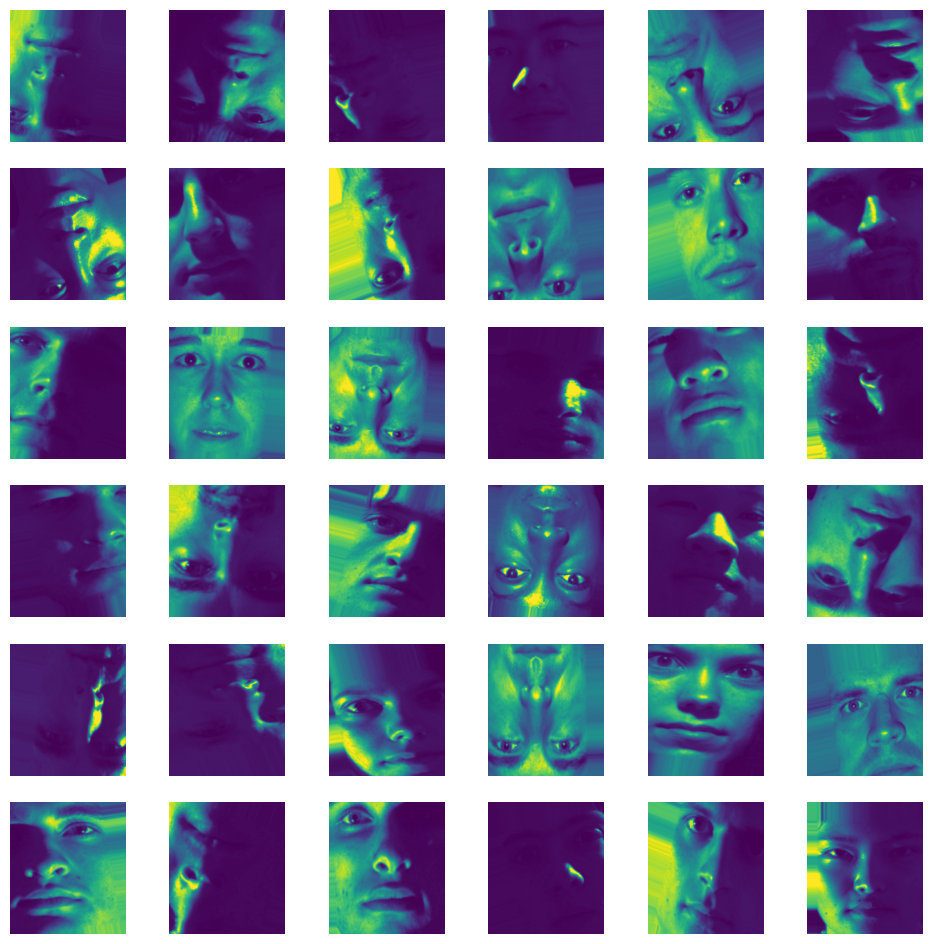

In [ ]:
# Preview ba3d el augmentation
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
for i in range(6):
    for j in range(6):
        ax[i,j].imshow(augmented_data.next()[0][0])
        ax[i,j].axis('off')
plt.show()

# Re-train models with augmented

Training the same models but on the modified dataset `[Hyperparameters might change according to the new dataset properties]`

In [ ]:
# train and test el MLP 3al modified dataset
history_MLP_augmented = model_MLP.fit(X_train_augmented, y_train_augmented, epochs=6, callbacks=earlystopping, validation_data=(X_val_test, y_val_test))
print('\n\n=========Modified MLP Evaluation On Test Set=========')
results_MLP_augmented = model_MLP.evaluate(X_test, y_test)
print('\n\n')

history_CNN_augmented = model_CNN.fit(X_train_augmented, y_train_augmented, epochs=2, callbacks=earlystopping, validation_data=(X_val_test, y_val_test))
print('\n\n=========Modified CNN Evaluation On Test Set=========')
results_CNN_augmented = model_CNN.evaluate(X_test, y_test)
print('\n\n')

Epoch 1/6
121/121 [==============================] - 1s 7ms/step - loss: 2.0016 - accuracy: 0.4777 - val_loss: 0.6678 - val_accuracy: 0.8095
Epoch 2/6
121/121 [==============================] - 1s 6ms/step - loss: 1.9052 - accuracy: 0.4868 - val_loss: 0.5911 - val_accuracy: 0.8219
Epoch 3/6
121/121 [==============================] - 1s 6ms/step - loss: 1.8910 - accuracy: 0.4868 - val_loss: 0.7056 - val_accuracy: 0.8157
Epoch 4/6
121/121 [==============================] - 1s 6ms/step - loss: 1.8515 - accuracy: 0.4953 - val_loss: 0.7307 - val_accuracy: 0.8054
Epoch 5/6
121/121 [==============================] - 1s 6ms/step - loss: 1.8357 - accuracy: 0.4977 - val_loss: 0.8237 - val_accuracy: 0.7909
Epoch 6/6
121/121 [==============================] - 1s 6ms/step - loss: 1.7896 - accuracy: 0.5039 - val_loss: 0.6820 - val_accuracy: 0.8199


=========Modified MLP Evaluation On Test Set=========
8/8 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.8264



Epoch 1/2


Here, we can observe the change in evaluation on unseen data for the original dataset `Versus` the modified dataset.

In [ ]:
# karen el adem bel gedeed
print('{:<30} {:<20} {:<20}'.format('', 'Loss', 'Accuracy'))
print('{:<30} {:<20.4f} {:<20.4f}'.format('MLP (no augmentation)', results_MLP[0], results_MLP[1]))
print('{:<30} {:<20.4f} {:<20.4f}'.format('MLP (with augmentation)', results_MLP_augmented[0], results_MLP_augmented[1]))
print('{:<30} {:<20.4f} {:<20.4f}'.format('CNN (no augmentation)', results_CNN[0], results_CNN[1]))
print('{:<30} {:<20.4f} {:<20.4f}'.format('CNN (with augmentation)', results_CNN_augmented[0], results_CNN_augmented[1]))

                               Loss                 Accuracy            
MLP (no augmentation)          0.6714               0.8306              
MLP (with augmentation)        0.6941               0.8264              
CNN (no augmentation)          0.6194               0.8678              
CNN (with augmentation)        0.6766               0.8802              




=========Modified MLP Metrics Plot=========


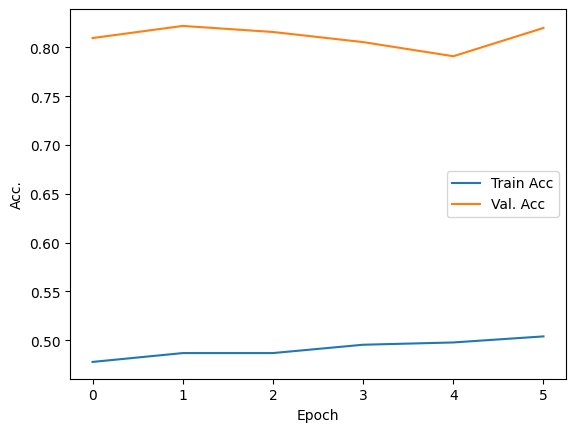

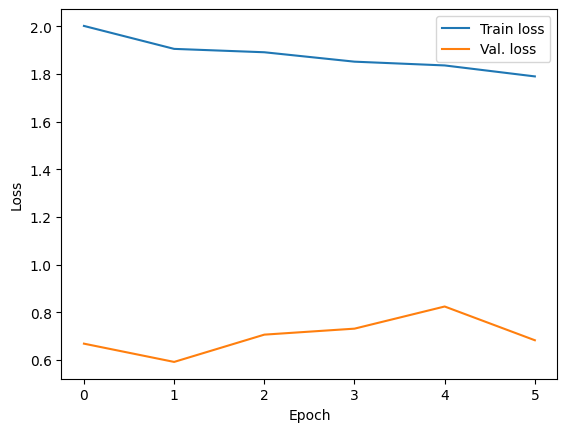






=========Modified CNN Metrics Plot=========


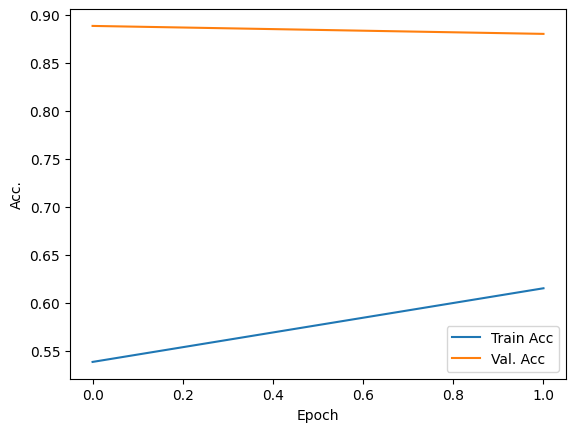

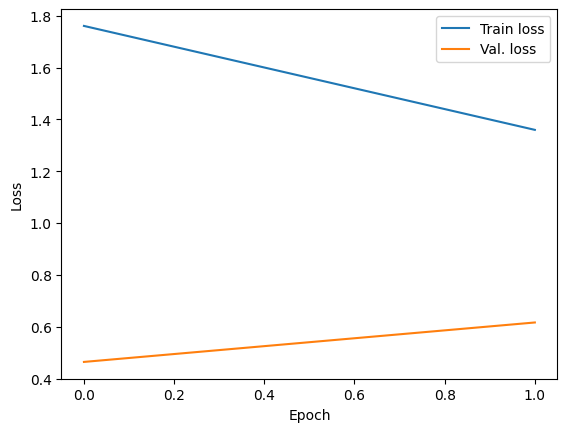

In [ ]:
print('\n\n=========Modified MLP Metrics Plot=========')
compare_metrics(history_MLP_augmented)
print('\n\n')

print('\n\n=========Modified CNN Metrics Plot=========')
compare_metrics(history_CNN_augmented)
print('\n\n')
